In [1]:
!pip install git+https://github.com/qubvel/segmentation_models

  Running command git submodule update --init --recursive -q


In [2]:
!pip install opencv-python

In [1]:
import pandas as pd

In [2]:
## import tensorflow as tf
import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import keras 

from keras.utils import normalize
from keras.metrics import MeanIoU
from keras.utils import to_categorical

#Resizing images, if needed
SIZE_X = 128 
SIZE_Y = 128
n_classes = 47 #Number of classes for segmentation

DATA_DIR = './preprocess_data/data/'

TRAIN_IMG = 'train_images/'
TRAIN_MASK = 'train_labels/'

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [3]:
ALLOWED_EXTENSIONS = ['jpg','JPG','jpeg','JPEG','png','PNG']
def allowed_file(filename):
    return '.' in filename and filename.rsplit('.', 1)[1].lower() in ALLOWED_EXTENSIONS

In [4]:
train_image_names = [filename for filename in os.listdir(DATA_DIR + TRAIN_IMG) if allowed_file(filename)]

In [5]:
#Capture training image info as a list
train_images = []
train_masks = [] 

for img_name in train_image_names:
    img = cv2.cvtColor(cv2.imread(DATA_DIR + TRAIN_IMG + img_name), 1)
    mask = np.load(DATA_DIR + TRAIN_MASK + img_name.split('.')[0] + '.npy')
    
    train_images.append(img)
    train_masks.append(mask)
       
    
train_images = np.array(train_images)
train_masks = np.array(train_masks)

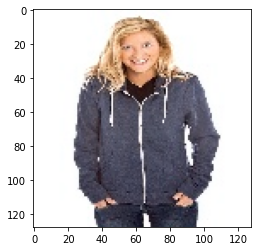

In [6]:
plt.imshow(train_images[5])

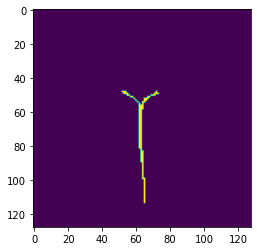

In [7]:
plt.imshow(train_masks[5])

In [8]:
pd.Series(train_masks[3].flatten()).unique()

array([ 0, 42], dtype=uint8)

In [9]:
# ###############################################
# #Encode labels... but multi dim array so need to flatten, encode and reshape
# from sklearn.preprocessing import LabelEncoder
# labelencoder = LabelEncoder()
# n, h, w = train_masks.shape
# train_masks_reshaped = train_masks.reshape(-1,1)
# train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
# train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

# np.unique(train_masks_encoded_original_shape)

In [11]:
train_masks.shape

(92, 128, 128)

In [10]:
train_masks_input = np.expand_dims(train_masks, axis=3)

#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

#Further split training data t a smaller subset for quick testing of models
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.5, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 

from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))



test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

Class values in the dataset are ...  [ 0  3  5  6  9 10 12 14 15 16 18 20 21 22 23 24 25 26 27 28 29 30 33 34
 35 36 37 40 42 43 45 46]


In [18]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=32, dim=(32,32,32), n_channels=1,
                 n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
#         X = np.empty((self.batch_size, *self.dim, self.n_channels))
#         y = np.empty((self.batch_size, *self.dim), dtype=int)

        # Generate data
        train_images = []
        train_masks = [] 

        for img_name in list_IDs_temp:
            img = cv2.cvtColor(cv2.imread(DATA_DIR + TRAIN_IMG + img_name), 1)
            mask = np.load(DATA_DIR + TRAIN_MASK + img_name.split('.')[0] + '.npy')

            train_images.append(img)
            train_masks.append(mask)


        train_images = np.array(train_images)
        train_masks = np.array(train_masks)
        
        
        train_masks_input = np.expand_dims(train_masks, axis=3)
            
        train_masks_cat = to_categorical(train_masks_input, num_classes=n_classes)
        y_train_cat = train_masks_cat.reshape((train_masks_input.shape[0], train_masks_input.shape[1], train_masks_input.shape[2], n_classes))


#         for i, ID in enumerate(list_IDs_temp):
#             # Store sample
#             X[i,] = cv2.cvtColor(cv2.imread(DATA_DIR + TRAIN_IMG + ID), 1)

#             # Store class
#             y[i] = np.load(DATA_DIR + TRAIN_MASK + ID.split('.')[0] + '.npy')
            
#         y = np.expand_dims(y, axis=3)
#         train_masks_cat = to_categorical(y, num_classes=n_classes)
#         y_train_cat = train_masks_cat.reshape((y.shape[0], y.shape[1], y.shape[2], n_classes))

        return train_images, y_train_cat

In [19]:
activation='softmax'

LR = 0.0001
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss() 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [20]:
# Parameters
params = {'dim': (128,128),
          'batch_size': 8,
          'n_classes': n_classes,
          'n_channels': 3,
          'shuffle': True}

# Datasets


# Generators
training_generator = DataGenerator(train_image_names, **params)
validation_generator = DataGenerator(train_image_names, **params)

In [30]:
next(iter(training_generator))[1].shape

(8, 128, 128, 47)

In [31]:
########################################################################
###Model 1
BACKBONE1 = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

# # preprocess input
# X_train1 = preprocess_input1(X_train)
# X_test1 = preprocess_input1(X_test)

# define model
model1 = sm.Unet(BACKBONE1, encoder_weights='imagenet', classes=n_classes, activation=activation)

# compile keras model with defined optimozer, loss and metrics
model1.compile(optim, total_loss, metrics=metrics)

#model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

# print(model1.summary())

In [ ]:
model1.fit(training_generator,
#                     validation_data=validation_generator,
                    )

Epoch 1/1


In [ ]:
history1=model1.fit(X_train1, 
          y_train_cat,
          batch_size=8, 
          epochs=50,
          verbose=1,
          validation_data=(X_test1, y_test_cat))


model1.save('res34_backbone_50epochs.hdf5')

In [ ]:
##########################################################

###
#plot the training and validation accuracy and loss at each epoch
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history1.history['iou_score']
val_acc = history1.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

Mean IoU = 0.011823413


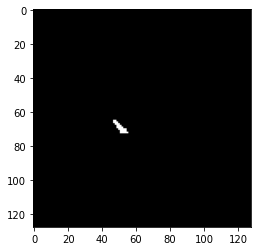

In [23]:
#####################################################

from keras.models import load_model

### FOR NOW LET US FOCUS ON A SINGLE MODEL

#Set compile=False as we are not loading it for training, only for prediction.
model1 = load_model('res34_backbone_50epochs.hdf5', compile=False)
# model2 = load_model('saved_models/inceptionv3_backbone_50epochs.hdf5', compile=False)
# model3 = load_model('saved_models/vgg19_backbone_50epochs.hdf5', compile=False)

#IOU
y_pred1=model1.predict(X_test1)
y_pred1_argmax=np.argmax(y_pred1, axis=3)


#Using built in keras function
#from keras.metrics import MeanIoU
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred1_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


# #To calculate I0U for each class...
# values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
# print(values)
# class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
# class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
# class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
# class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

# print("IoU for class1 is: ", class1_IoU)
# print("IoU for class2 is: ", class2_IoU)
# print("IoU for class3 is: ", class3_IoU)
# print("IoU for class4 is: ", class4_IoU)

#Vaerify the prediction on first image
plt.imshow(train_images[0, :,:,0], cmap='gray')
plt.imshow(train_masks[0], cmap='gray')

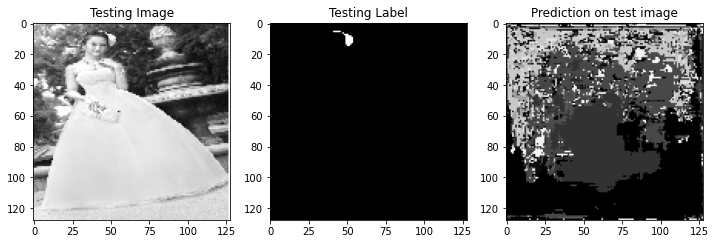

In [26]:
# Test some random images
import random
test_img_number = random.randint(0, len(X_test1))
test_img = X_test1[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input1 = preprocess_input1(test_img_input)

test_pred1 = model1.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1, cmap='gray')
plt.show()